In [21]:
from scipy.sparse import identity, csr_matrix, coo_matrix
from scipy.sparse.linalg import spsolve
import geopandas as gpd
import numpy as np
from libpysal import graph
from libpysal.weights import Queen,Rook
import matplotlib.pyplot as plt
from esda.moran import Moran
from shapely.geometry import Polygon
from hilbertcurve.hilbertcurve import HilbertCurve
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster
from copy import deepcopy
import seaborn as sn 
import spopt
from tools import generate_square_lattice,build_g,remove_random_edges
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
#from spreg import ML_Error

In [10]:
l = 16
gdf = generate_square_lattice(l)

In [11]:

xs, ys = np.meshgrid(np.arange(l), np.arange(l))
coords = np.column_stack((xs.flatten(), ys.flatten()))

p = int(np.log2(l))
hc = HilbertCurve(p, 2)

# Compute Hilbert indices one by one
indices = [hc.distance_from_point([x, y]) for x, y in coords]

# Reshape if you want 2D
hilbert_array = np.array(indices).reshape(l, l)

gdf["hilbert_index"] = indices

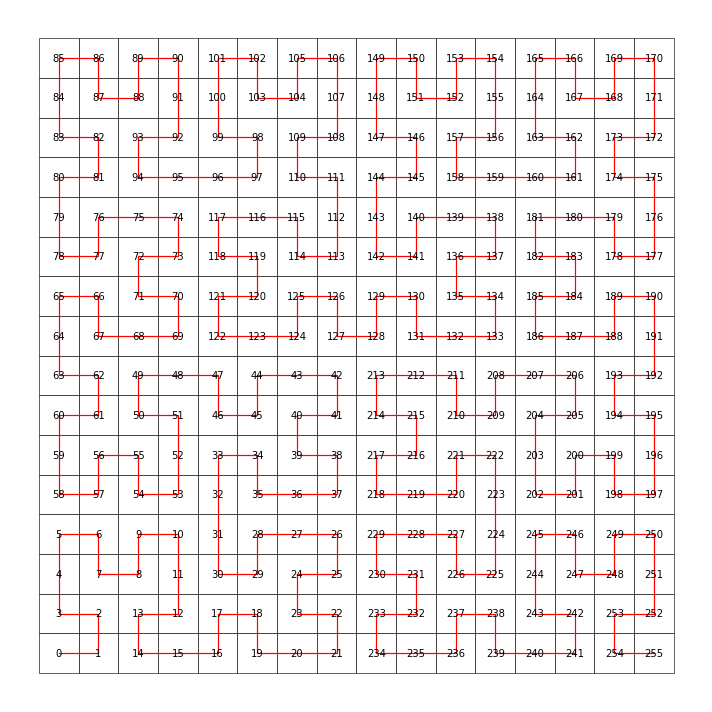

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

# Polygons: no fill, black boundaries
gdf.plot(
    facecolor="white",
    edgecolor="black",
    linewidth=0.6,
    ax=ax
)

# Sort by Hilbert index
gdf_sorted = gdf.sort_values("hilbert_index").copy()
gdf_sorted["centroid"] = gdf_sorted.geometry.centroid

# Hilbert curve (black line)
ax.plot(
    gdf_sorted["centroid"].x,
    gdf_sorted["centroid"].y,
    color="red",
    linewidth=1.2,
    zorder=3
)

# Index labels
for _, row in gdf_sorted.iterrows():
    c = row["centroid"]
    ax.text(
        c.x, c.y,
        str(row["hilbert_index"]),
        ha="center",
        va="center",
        fontsize=10,
        color="black",
        zorder=4
    )

ax.set_axis_off()
plt.tight_layout()



In [12]:
g_correct = build_g(gdf)

c:\Users\elapo\anaconda3\envs\geopython\lib\site-packages\libpysal\graph\_utils.py:109: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  idxs = idxs.fillna(pd.Series(idxs.index, index=idxs.index))  # self-loops


In [6]:
agg16 = cluster.AgglomerativeClustering(n_clusters=16, connectivity=g_correct.sparse)
agg16

AgglomerativeClustering(connectivity=<256x256 sparse array of type '<class 'numpy.float64'>'
	with 960 stored elements in COOrdinate format>,
                        n_clusters=16)

In [7]:
agg16.fit(gdf[["hilbert_index"]])

AgglomerativeClustering(connectivity=<256x256 sparse array of type '<class 'numpy.float64'>'
	with 960 stored elements in COOrdinate format>,
                        n_clusters=16)

In [8]:
gdf["agg_16"] = agg16.labels_
ground_truth = agg16.labels_
regions = gdf.dissolve(by="agg_16")

(-0.8, 16.8, -0.8, 16.8)

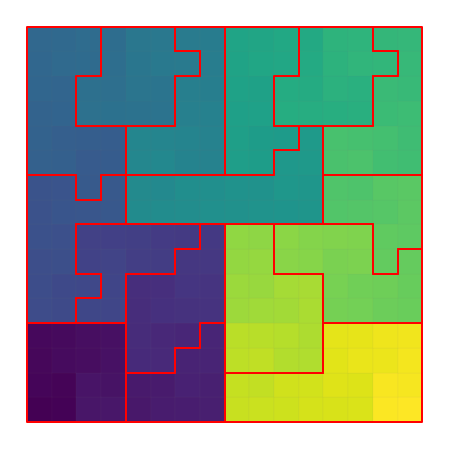

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

# Fill polygons with Hilbert index
gdf.plot(column="hilbert_index", cmap="viridis", linewidth=0.05, edgecolor="gray", ax=ax)

# Overlay the region borders
regions.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

ax.axis("off")


In [ ]:
w_correct=g_correct.to_W()
w_correct_sparse = w_correct.sparse


In [14]:
n_polygons = len(gdf)

In [ ]:
from scipy.sparse.csgraph import connected_components
import warnings

n_runs = 100
perc_missing = np.arange(0.05, 0.55, 0.05)
labels_array = np.full((len(perc_missing), n_runs, n_polygons), -1)


for run in range (n_runs):
    for j,p in enumerate(perc_missing):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="The weights matrix is not fully connected")
            w_new = remove_random_edges(w_correct_sparse, p)
            w_corrupt = graph.Graph.from_sparse(w_new, ids=g_correct.unique_ids).to_W()
        n_components, _ = connected_components(w_corrupt.sparse)
        if n_components > 1:
            print(f"Skipping p={p:.2f}, run={run} (disconnected)")
            continue
        
        agg16 = cluster.AgglomerativeClustering(n_clusters=16, connectivity=w_corrupt.sparse)
        agg16.fit(gdf[["hilbert_index"]])
        labels_array[j, run, :] = agg16.labels_
        #gdf[f"agg_corrupt_{int(p*100)}_run_{n}"] = agg16.labels_
        """
        # Dissolve to get region boundaries
        regions_corrupt = gdf.dissolve(by=f"agg_corrupt_{int(p*100)}")
        
        fig, ax = plt.subplots(figsize=(8,8))

        # Layer 1: polygons colored by Hilbert index
        gdf.plot(column="hilbert_index", cmap="viridis", ax=ax)

        # Layer 2: Rook edges
        regions_corrupt.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

        ax.set_title(f"Agglomerative, {int(p*100)} % edges missing")
        ax.axis("off")
        
        plt.tight_layout()
        plt.show()"""

Skipping p=0.20, run=0 (disconnected)
Skipping p=0.25, run=0 (disconnected)
Skipping p=0.30, run=0 (disconnected)
Skipping p=0.35, run=0 (disconnected)
Skipping p=0.40, run=0 (disconnected)
Skipping p=0.45, run=0 (disconnected)
Skipping p=0.50, run=0 (disconnected)
Skipping p=0.15, run=1 (disconnected)
Skipping p=0.25, run=1 (disconnected)
Skipping p=0.30, run=1 (disconnected)
Skipping p=0.35, run=1 (disconnected)
Skipping p=0.40, run=1 (disconnected)
Skipping p=0.45, run=1 (disconnected)
Skipping p=0.50, run=1 (disconnected)
Skipping p=0.15, run=2 (disconnected)
Skipping p=0.20, run=2 (disconnected)
Skipping p=0.25, run=2 (disconnected)
Skipping p=0.30, run=2 (disconnected)
Skipping p=0.35, run=2 (disconnected)
Skipping p=0.40, run=2 (disconnected)
Skipping p=0.45, run=2 (disconnected)
Skipping p=0.50, run=2 (disconnected)
Skipping p=0.10, run=3 (disconnected)
Skipping p=0.20, run=3 (disconnected)
Skipping p=0.25, run=3 (disconnected)
Skipping p=0.30, run=3 (disconnected)
Skipping p=0

In [13]:
import pandas as pd

valid_counts = np.sum(np.any(labels_array != -1, axis=2), axis=1)
total_runs = labels_array.shape[1]

summary = pd.DataFrame({
    "perc_missing": perc_missing * 100,
    "valid_runs": valid_counts,
    "total_runs": total_runs,
    "valid_ratio": valid_counts / total_runs
})


In [14]:
summary

,perc_missing,valid_runs,total_runs,valid_ratio
0,5.0,97,100,0.97
1,10.0,86,100,0.86
2,15.0,68,100,0.68
3,20.0,30,100,0.30
4,25.0,11,100,0.11
5,30.0,0,100,0.00
6,35.0,0,100,0.00
7,40.0,0,100,0.00
8,45.0,0,100,0.00
9,50.0,0,100,0.00


In [15]:

ari_scores = np.full((len(perc_missing), n_runs), np.nan)

for j, p in enumerate(perc_missing):
    for run in range(n_runs):
        labels_pred = labels_array[j, run, :]
        # Skip missing (-1) entries
        if np.all(labels_pred == -1):
            continue
        ari_scores[j, run] = adjusted_rand_score(ground_truth, labels_pred)

NameError: name 'perc_missing' is not defined

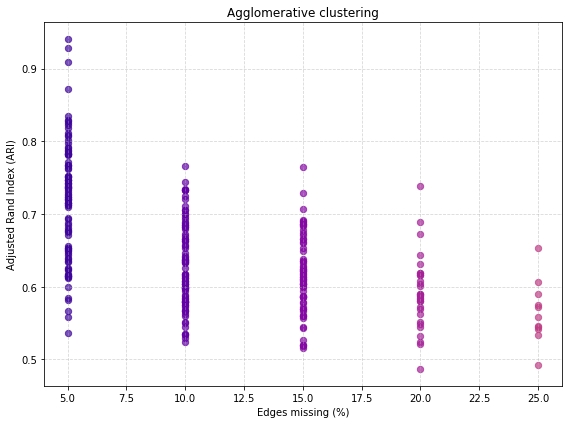

In [18]:

plt.figure(figsize=(8, 6))
palette = sns.color_palette("plasma", len(perc_missing))

for j, p in enumerate(perc_missing):
    # Plot one vertical column of dots for each % missing
    plt.scatter([p * 100] * n_runs,
                ari_scores[j, :],
                color=palette[j],
                alpha=0.7,
                s=40)

plt.xlabel("Edges missing (%)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("Agglomerative clustering")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

In [16]:
model_true = spopt.region.Skater(
    gdf,
    w_correct,
        ["hilbert_index"],
        n_clusters=16)
model_true.solve()
ground_truth_skater = model_true.labels_

In [17]:
perc_missing_skater = np.arange(0, 1, 0.05)
n_runs_skater = 10


In [ ]:
labels_array_skater = np.full((len(perc_missing_skater), n_runs_skater, n_polygons), -1)
for run in range(n_runs_skater):
    for j,p in enumerate(perc_missing_skater):
        # 1️⃣ Corrupt the edges
        w_new = remove_random_edges(w_correct_sparse, p)
        w_corrupt = graph.Graph.from_sparse(w_new, ids=g_correct.unique_ids).to_W()
        model = spopt.region.Skater(
        gdf,
        w_corrupt,
        ["hilbert_index"],
        n_clusters=16)
        model.solve()
        labels_array_skater[j, run, :] = model.labels_
    
    
    
    
    """
    regions_corrupt = gdf.dissolve(by=f"skater_{int(p*100)}")
    fig, ax = plt.subplots(figsize=(8,8))

    # Layer 1: polygons colored by Hilbert index
    gdf.plot(column="hilbert_index", cmap="viridis", ax=ax)

    # Layer 2: Rook edges
    regions_corrupt.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

    ax.set_title(f"SKATER, {int(p*100)} edges missing")
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()"""

In [5]:
loaded_res=np.load("labels_skater.npy")

In [18]:
ari_scores_skater = np.full((len(perc_missing_skater), n_runs_skater), np.nan)

for j, p in enumerate(perc_missing_skater):
    for run in range(n_runs_skater):
        labels_pred = loaded_res[j, run, :]
        # Skip missing (-1) entries
        if np.all(labels_pred == -1):
            continue
        ari_scores_skater[j, run] = adjusted_rand_score(ground_truth_skater, labels_pred)

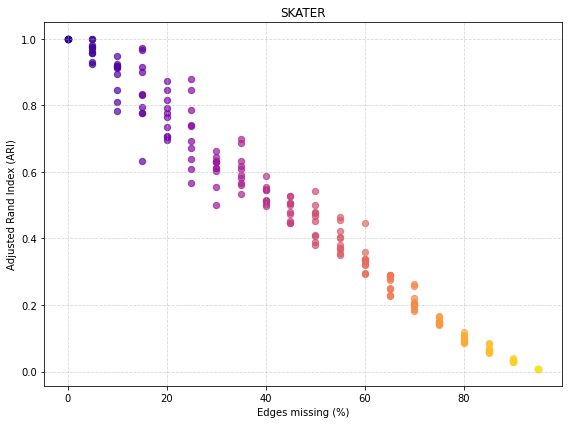

In [24]:
plt.figure(figsize=(8, 6))
palette = sns.color_palette("plasma", len(perc_missing_skater))

for j, p in enumerate(perc_missing_skater):
    # Plot one vertical column of dots for each % missing
    plt.scatter([p * 100] * n_runs_skater,
                ari_scores_skater[j, :],
                color=palette[j],
                alpha=0.7,
                s=40)

plt.xlabel("Edges missing (%)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("SKATER")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

In [3]:
loaded_res

array([[[  0,   0,   0, ...,  14,  14,  14],
        [  0,   0,   0, ...,  14,  14,  14],
        [  0,   0,   0, ...,  14,  14,  14],
        ...,
        [  0,   0,   0, ...,  14,  14,  14],
        [  0,   0,   0, ...,  14,  14,  14],
        [  0,   0,   0, ...,  14,  14,  14]],

       [[  0,   0,   0, ...,  15,  15,  15],
        [  0,   0,   0, ...,  14,  14,  14],
        [  0,   0,   0, ...,  14,  14,  14],
        ...,
        [  0,   0,   0, ...,  15,  15,  15],
        [  0,   0,   0, ...,  15,  15,  15],
        [  0,   0,   0, ...,  13,  13,  13]],

       [[  0,   0,   0, ...,  15,  15,  15],
        [  0,   0,   0, ...,  15,  15,  15],
        [  0,   0,   0, ...,  15,  15,  15],
        ...,
        [  0,   0,   0, ...,  16,  16,  16],
        [  0,   0,   0, ...,  15,  15,  15],
        [  0,   0,   0, ...,  15,  15,  15]],

       ...,

       [[  0,   1,   2, ..., 197, 198, 199],
        [  0,   1,   2, ..., 198, 198, 199],
        [  0,   1,   2, ..., 186, 199, 199